In [6]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.datasets import mnist
import numpy as np

encoding_size = 32
input_size = 784

input_image = Input(shape=(input_size,))
encoded_input = Input(shape=(encoding_size,))

# Performs the encoding from the input image of size 784 to the encoding of size 32
encoded = Dense(encoding_size, activation='relu')(input_image)
# Takes the encoded image and creates a layer to decode it back to size 784
decoded = Dense(input_size, activation='sigmoid')(encoded)
# Creates the mapping from the input_image => decoded (via the encoder and decoder layers)
autoencoder = Model(input_image, decoded)

# Allows us to access the mapping from input_image => encoded
encoder = Model(input_image, encoded) 
# Looks at the just the decoded layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]

# Creates the mapping from the encoded input => decoded (if you already have the encoding)
decoder = Model(encoded_input, decoder_layer(encoded_input))
# Shouldn't this be the same as this?
# decoder = Model(encoded_input, decoded(encoded_input))

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')


(x_train, trash), (x_test, also_trash) = mnist.load_data()

# Normalize 255 integer space into into 0 to 1 floats
x_train = x_train.astype('float32')/255.
x_test = x_test.astype('float32')/255.

# Reshape the size of tensor (num_samples, 28, 28) to matrix (num_samples, 28*28)
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print(x_train.shape)
print(x_test.shape)

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

(60000, 784)
(10000, 784)
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 7s - loss: 0.3791 - val_loss: 0.2732
Epoch 2/50
60000/60000 [==============================] - 6s - loss: 0.2663 - val_loss: 0.2561ss:  - ETA: 0s - loss: 
Epoch 3/50
60000/60000 [==============================] - 6s - loss: 0.2466 - val_loss: 0.2347
Epoch 4/50
60000/60000 [==============================] - 6s - loss: 0.2265 - val_loss: 0.2160
Epoch 5/50
60000/60000 [==============================] - 7s - loss: 0.2104 - val_loss: 0.2025
Epoch 6/50
60000/60000 [==============================] - 5s - loss: 0.1991 - val_loss: 0.1930
Epoch 7/50
60000/60000 [==============================] - 5s - loss: 0.1907 - val_loss: 0.1856
Epoch 8/50
60000/60000 [==============================] - 5s - loss: 0.1839 - val_loss: 0.1794
Epoch 9/50
60000/60000 [==============================] - 7s - loss: 0.1779 - val_loss: 0.1738
Epoch 10/50
60000/60000 [=====================

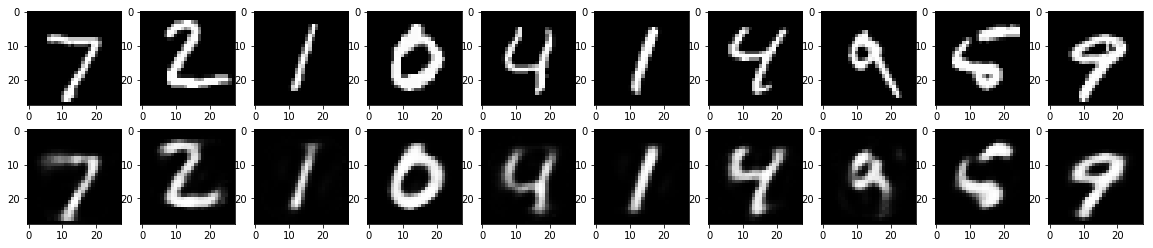

In [9]:

encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)
import matplotlib.pyplot as plt

n=10

plt.figure(figsize=(20,4))

for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28,28))
    plt.gray()
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_imgs[i].reshape(28,28))
    plt.gray()
plt.show()


In [26]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.callbacks import TensorBoard
from keras import backend as K


number_filters_per_layer = [16, 8, 8]
size_filter_per_layer = (3,3)
pooling_size = (2,2)

input_image = Input(shape=(28, 28, 1))
first_conv_layer = Conv2D(16, (3,3), activation='relu', padding='same')(input_image)
first_pool_layer = MaxPooling2D((2,2), padding='same')(first_conv_layer)
second_conv_layer = Conv2D(8, (3,3), activation='relu', padding='same')(first_pool_layer)
second_pool_layer = MaxPooling2D((2,2), padding='same')(second_conv_layer)
third_conv_layer = Conv2D(8, (3,3), activation='relu', padding='same')(second_pool_layer)
third_pool_layer = MaxPooling2D((2,2), padding='same')(third_conv_layer)

encoded_image = third_pool_layer

first_deconv_layer = Conv2D(8, (3,3), activation='relu', padding='same')(encoded_image)
first_upsample_layer = UpSampling2D((2,2))(first_deconv_layer)
second_deconv_layer = Conv2D(8, (3,3), activation='relu', padding='same')(first_upsample_layer)
second_upsample_layer = UpSampling2D((2,2))(second_deconv_layer)
third_deconv_layer = Conv2D(16, (3,3), activation='relu')(second_upsample_layer)
third_upsample_layer = UpSampling2D((2,2))(third_deconv_layer)

fully_connected_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(third_upsample_layer)

decoded_image = fully_connected_layer
autoencoder = Model(input_image, decoded_image)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

from keras.datasets import mnist

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 102s - loss: 0.2350 - val_loss: 0.1847
Epoch 2/10
60000/60000 [==============================] - 100s - loss: 0.1697 - val_loss: 0.1638
Epoch 3/10
60000/60000 [==============================] - 101s - loss: 0.1539 - val_loss: 0.1520
Epoch 4/10
60000/60000 [==============================] - 102s - loss: 0.1446 - val_loss: 0.1411
Epoch 5/10
60000/60000 [==============================] - 101s - loss: 0.1383 - val_loss: 0.1363
Epoch 6/10
60000/60000 [==============================] - 103s - loss: 0.1342 - val_loss: 0.1305
Epoch 7/10
60000/60000 [==============================] - 104s - loss: 0.1308 - val_loss: 0.1273
Epoch 8/10
60000/60000 [==============================] - 106s - loss: 0.1279 - val_loss: 0.1268
Epoch 9/10
60000/60000 [==============================] - 123s - loss: 0.1256 - val_loss: 0.1225
Epoch 10/10
60000/60000 [==============================] - 112s - loss: 0.123

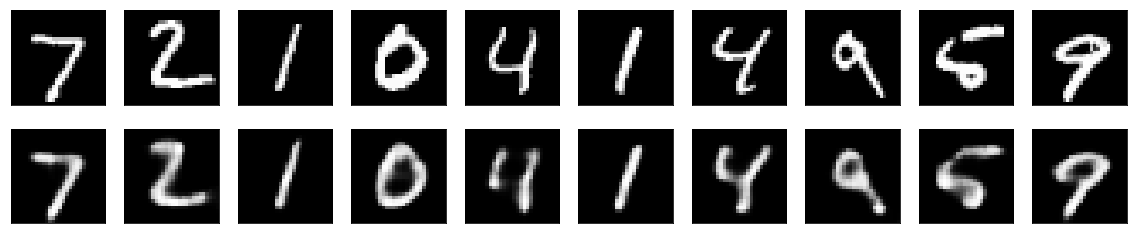

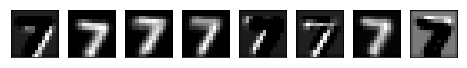

(3, 3, 1, 16)


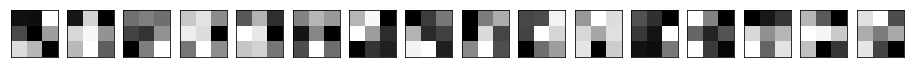

In [61]:
decoded_imgs = autoencoder.predict(x_test)

# encoder = Model(input_image, encoded_image)
# encoded_imgs = encoder.predict(x_test)

# print(encoded_imgs[0].shape)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n +1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

first_layer_encoder = Model(input_image, second_conv_layer)
encoded_imgs = first_layer_encoder.predict(x_test)
first_image = encoded_imgs[0]

(width, height, depth) = first_image.shape

plt.figure(figsize=(depth, 4))
for i in range(depth):
    ax = plt.subplot(1, depth, i+1)
    plt.imshow(first_image[:, :, i].reshape(width, height))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


W = first_layer_encoder.get_weights()[0]
print(W.shape)
W = np.squeeze(W)

(width, height, depth) = W.shape

plt.figure(figsize=(depth, 4))
for i in range(depth):
    ax = plt.subplot(1, depth, i+1)
    plt.imshow(W[:, :, i].reshape(width, height))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
